In [1]:
import pandas as pd
#import category_encoders as ce
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import scipy.stats as stats
from scipy.stats import boxcox, probplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , confusion_matrix , classification_report, roc_curve, auc
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
import statsmodels.api as sm
import lime
import lime.lime_tabular


### Read Data

In [2]:
df=pd.read_csv('balanced_processed_data_all_v2.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
df.fillna(0,inplace=True)

In [4]:
df.describe().style.background_gradient(axis=None , cmap = "Blues" , vmin = 0 , vmax = 9000  )

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default,is_application_processed_on_weekday,is_client_graduate,is_client_accompanied_alone,Accompany_Client_Alone,Accompany_Client_Kids,Accompany_Client_Partner,Accompany_Client_Relative,Client_Income_Type_Commercial,Client_Income_Type_Govt Job,Client_Income_Type_Retired,Client_Income_Type_Service,Client_Education_Graduation,Client_Education_Graduation dropout,Client_Education_Junior secondary,Client_Education_Secondary,Client_Marital_Status_D,Client_Marital_Status_M,Client_Marital_Status_S,Client_Marital_Status_W,Client_Gender_Female,Client_Gender_Male,Loan_Contract_Type_CL,Loan_Contract_Type_RL,Client_Housing_Type_Family,Client_Housing_Type_Home,Client_Housing_Type_Municipal,Client_Housing_Type_Office,Client_Housing_Type_Rental,Client_Occupation_Accountants,Client_Occupation_Cleaning,Client_Occupation_Cooking,Client_Occupation_Core,Client_Occupation_Drivers,Client_Occupation_High skill tech,Client_Occupation_Laborers,Client_Occupation_Low-skill Laborers,Client_Occupation_Managers,Client_Occupation_Medicine,Client_Occupation_Private service,Client_Occupation_Sales,Client_Occupation_Secretaries,Client_Occupation_Security,Client_Occupation_Waiters/barmen,Type_Organization_Agriculture,Type_Organization_Bank,Type_Organization_Business Entity Type 1,Type_Organization_Business Entity Type 2,Type_Organization_Business Entity Type 3,Type_Organization_Construction,Type_Organization_Government,Type_Organization_Housing,Type_Organization_Industry: type 11,Type_Organization_Industry: type 3,Type_Organization_Industry: type 9,Type_Organization_Kindergarten,Type_Organization_Medicine,Type_Organization_Military,Type_Organization_Other,Type_Organization_Police,Type_Organization_Postal,Type_Organization_Restaurant,Type_Organization_School,Type_Organization_Security,Type_Organization_Security Ministries,Type_Organization_Self-employed,Type_Organization_Services,Type_Organization_Trade: type 2,Type_Organization_Trade: type 3,Type_Organization_Trade: type 7,Type_Organization_Transport: type 2,Type_Organization_Transport: type 3,Type_Organization_Transport: type 4,Type_Organization_University,Type_Organization_XNA,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
count,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,23971.000000,2397

In [5]:
#Drop columns list has been prepared in multiple iterations after checking multicolinearity
# Also models have been tested using imbalanced data set and then in this note book onlly final analysis and features has been preserved
y_cols='Default'


#Final list
drop_cols_list=['Mobile_Tag','Client_Gender_Female','Default','is_application_processed_on_weekday','Loan_Contract_Type_CL','Type_Organization_XNA',
                 'time_of_day_morning',  'time_of_day_evening', 'time_of_day_afternoon','time_of_day_night',                
                'Client_Marital_Status_M',
                'Client_Education_Graduation', 'Client_Education_Graduation dropout', 'Client_Education_Junior secondary', 'Client_Education_Secondary',
                'Client_Housing_Type_Home',    
                'Accompany_Client_Alone','is_client_accompanied_alone', 'Accompany_Client_Kids', 'Accompany_Client_Partner', 'Accompany_Client_Relative',
                'Child_Count']

x_cols=list(df.columns.drop(drop_cols_list))

#x_cols=df.columns.drop(y_cols)

In [6]:
subset_df=df

In [7]:
subset_df=subset_df.astype(float)

### Logit Model for feature  corelation and importance

In [10]:
X=subset_df[x_cols]
y=subset_df[y_cols]

In [8]:
X_logit = subset_df[x_cols]
y_logit = subset_df[y_cols]
X_logit = sm.add_constant(X_logit)
ols_model = sm.Logit(y_logit, X_logit).fit(method='bfgs')
pvalues_df = pd.DataFrame({'feature': ols_model.params.index, 'pvalue': np.round(ols_model.pvalues, 2)}).sort_values(by='pvalue', ascending=False).reset_index(drop=True)
pvalues_df = pvalues_df[(pvalues_df.pvalue<=0.05)&(pvalues_df.feature!='const')].reset_index(drop=True)
pvalues_df

         Current function value: 0.314462
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


C:\Users\crane\rca\Lib\site-packages\scipy\optimize\_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
C:\Users\crane\rca\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,feature,pvalue
0,Type_Organization_Industry: type 9,0.05
1,Type_Organization_Construction,0.01
2,Bike_Owned,0.01
3,Client_Occupation_Medicine,0.00
4,Client_Occupation_Security,0.00
5,Client_Occupation_Sales,0.00
6,Car_Owned,0.00
7,Client_Occupation_Drivers,0.00
8,Client_Occupation_Managers,0.00
9,Cleint_City_Rating,0.00


###  Multicolinearity Check

In [11]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Example usage
vif = calculate_vif(X)
vif.set_index("Variable",inplace=True)
#vif['VIF'].sort_values(ascending=False).to_csv('./data/output/VIF_3.csv')
vif['VIF'].sort_values(ascending=False).to_frame().style.background_gradient(axis=None , cmap = "Greens" , vmin = 0 , vmax = 9000  ) #.to_csv('./data/output/VIF_3.csv')


,VIF
Variable,
Client_Income_Type_Service,12.735603
Client_Income_Type_Commercial,6.457472
Type_Organization_Business Entity Type 3,4.721865
Car_Owned,4.210377
Own_House_Age,3.944437
Client_Gender_Male,3.524391
Type_Organization_Self-employed,3.179726
Client_Occupation_Laborers,3.145093
Client_Income_Type_Govt Job,2.836536


###  Prepare train test and Split Data

In [12]:
#split data into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


### Tree based model to check feature importance

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

print("Training Set Metrics:")
print(classification_report(y_train, y_pred_train))
# Evaluate the model
print("Training score:")
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Training Set Metrics:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11300
         1.0       1.00      1.00      1.00      7876

    accuracy                           1.00     19176
   macro avg       1.00      1.00      1.00     19176
weighted avg       1.00      1.00      1.00     19176

Training score:
Accuracy: 0.9151199165797705
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      2826
         1.0       0.97      0.82      0.89      1969

    accuracy                           0.92      4795
   macro avg       0.93      0.90      0.91      4795
weighted avg       0.92      0.92      0.91      4795

Confusion Matrix:
[[2770   56]
 [ 351 1618]]


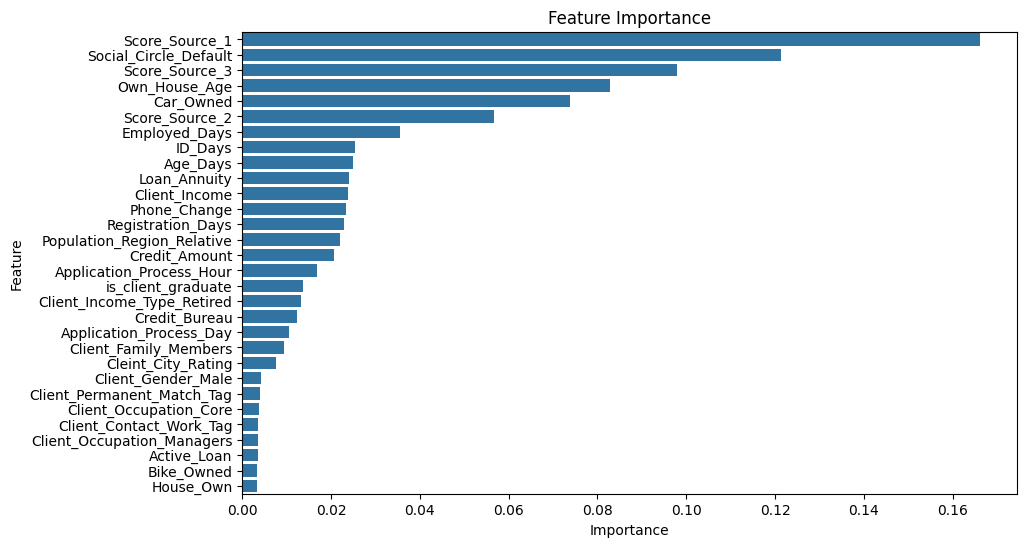

In [14]:
# Extract feature importance
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(30))
plt.title('Feature Importance')
plt.show()

### Logistic Regression

Training Set Metrics:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     11300
         1.0       0.88      0.82      0.85      7876

    accuracy                           0.88     19176
   macro avg       0.88      0.87      0.87     19176
weighted avg       0.88      0.88      0.88     19176


Testing Set Metrics:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90      2826
         1.0       0.88      0.81      0.84      1969

    accuracy                           0.88      4795
   macro avg       0.88      0.87      0.87      4795
weighted avg       0.88      0.88      0.88      4795

Confusion Matrix:


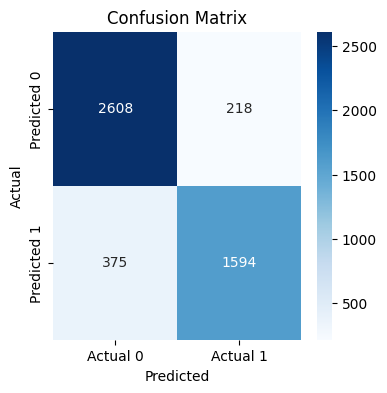


Additional Metrics:
Accuracy: 0.8763
Precision: 0.8797
Recall: 0.8095
F1 Score: 0.8432


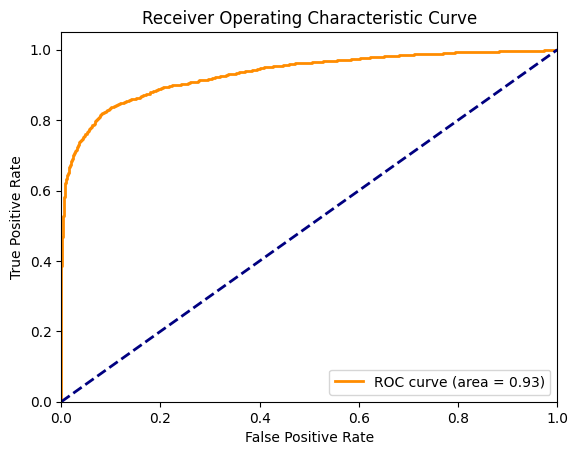

In [15]:


def logistic_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Training Set Metrics:")
    print(classification_report(y_train, y_pred_train))
    print("\nTesting Set Metrics:")
    print(classification_report(y_test, y_pred_test))
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix:')
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', yticklabels=['Predicted 0', 'Predicted 1'], xticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\nAdditional Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_test):.4f}")

    # Calculate ROC curve and AUC
    y_prob_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


    return model, y_prob_test, y_pred_test

# Example usage
log_model, log_acquisition_prob, log_y_pred_test = logistic_model(X_train, X_test, y_train, y_test)




### Explain model using SHAP explainer

In [19]:
explainer = shap.Explainer(log_model.predict_proba, X_train)
shap_values = explainer(X_train)

   

PermutationExplainer explainer: 19177it [16:38, 19.14it/s]                                                             


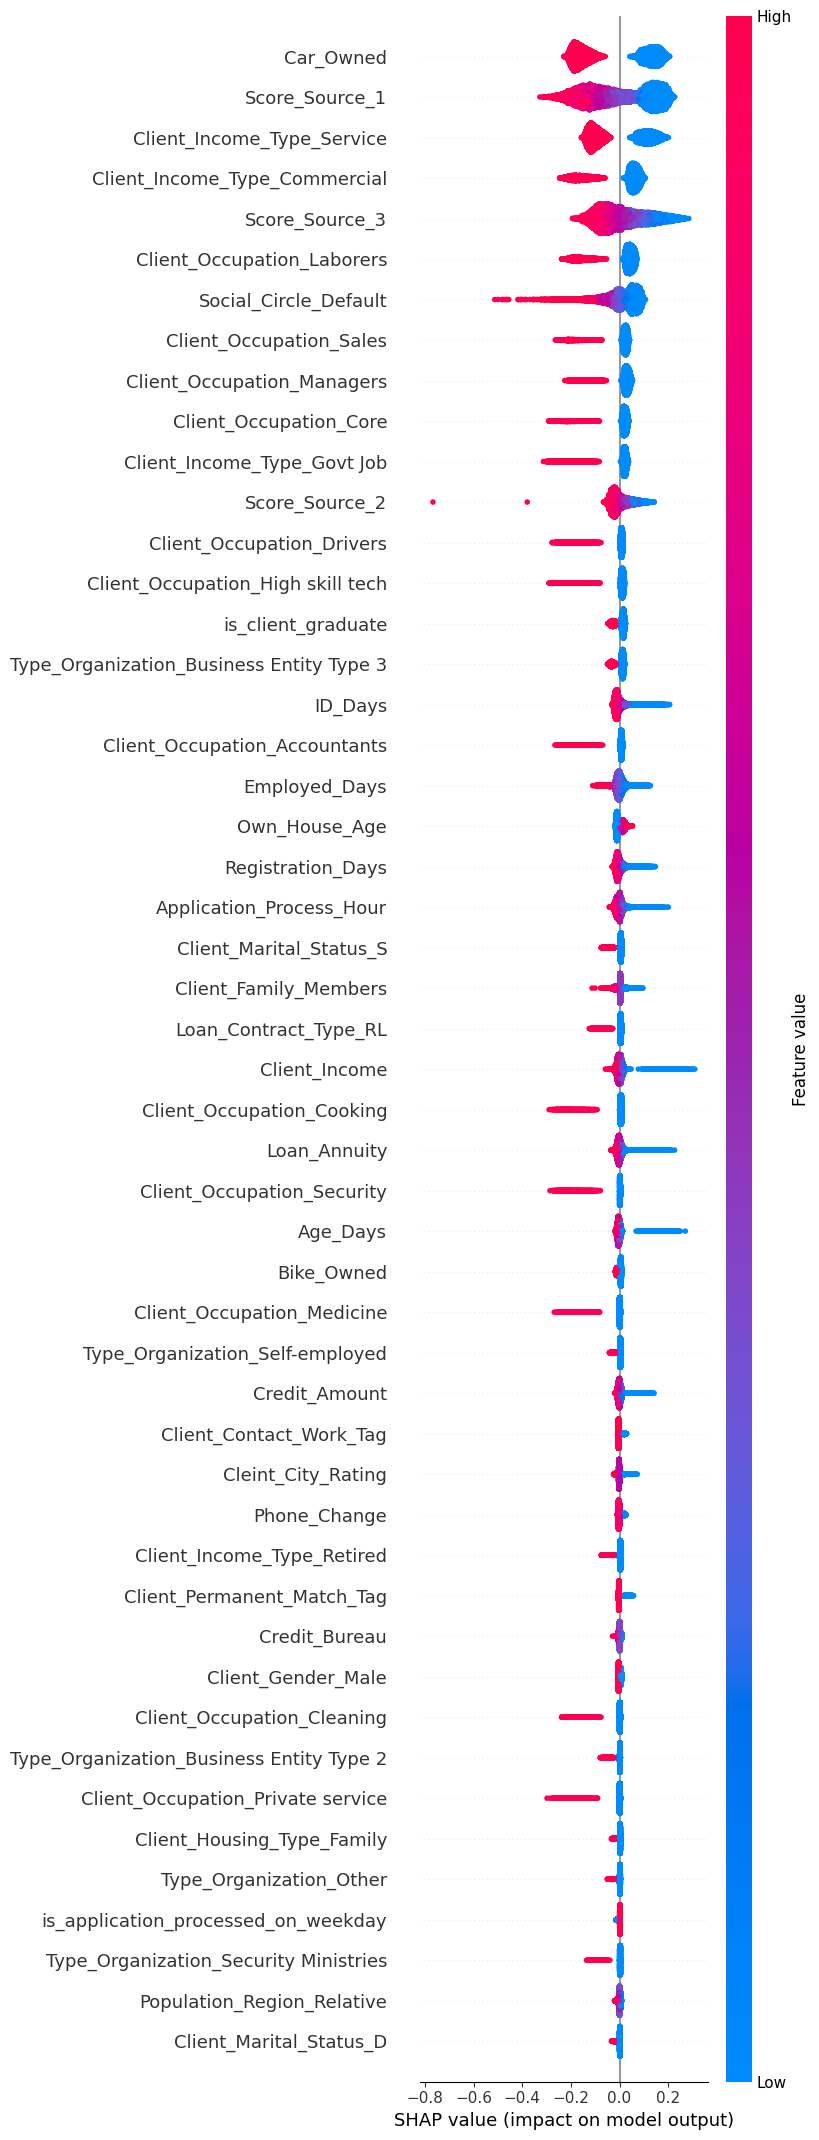

In [48]:
class_1_shap=[]
for ele in shap_values:
    class_1_shap.append(ele.values[:,1])

shap.summary_plot(np.array(class_1_shap), X_train,max_display=50)

From the above shape plots we can see the Client tends to be defaulter if:
1. If  Client is not graduate
2. if Source Score 1 and 3 is less then high chances of being Defaulter
3. If client's income type is not service, commercial or Govt job, then high chances of being defaulter
4. If client Employed Days is lower then high chances of being into Defaulter
5. If client occupation is not Managers, Sales, Laborers, then high chances of Defaulters
6. Lower  the client income, high is the chance of defaulter

And many other stories can be generated

### Generate model confidence zone

In [18]:
### Generate confidence intervals for predictions
#Do resampling on train data and train model on various samples on train data in 20 iterations to check how our model prediction range varies based on difference in training data
# Generate comfidence score and also confidence model 

In [21]:
from sklearn.utils import resample
 
def bootstrap_predictions(model, X_train, y_train, X_test, n_bootstrap=20):
    """Generate bootstrap samples and return the mean and confidence interval for predictions."""
    bootstrap_preds = np.zeros((n_bootstrap, X_test.shape[0]))
    for i in range(n_bootstrap):
        X_resample, y_resample = resample(X_train, y_train)
        model.fit(X_resample, y_resample)
        bootstrap_preds[i] = model.predict_proba(X_test)[:, 1]
    mean_preds = np.mean(bootstrap_preds, axis=0)
    lower_bound = np.percentile(bootstrap_preds, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_preds, 97.5, axis=0)
 
    return mean_preds, lower_bound, upper_bound 
 
mean_preds, lower_bound, upper_bound = bootstrap_predictions(log_model, X_train, y_train, X_test)
predict_defaulter = pd.DataFrame({
    'Actual' : y_test,
    'Model_prediction': log_y_pred_test,
    'bootstrap_mean_prob': mean_preds,
    'low_bound': lower_bound,
    'high_bound': upper_bound
}, index=X_test.index)
predict_defaulter['confidence_score']=1-(predict_defaulter['high_bound']-predict_defaulter['low_bound'])
predict_defaulter['confidence_zone']=np.where(predict_defaulter['confidence_score']>=0.75,'High',np.where(((predict_defaulter['confidence_score']>=0.50) & (predict_defaulter['confidence_score']<0.75)),'Medium',np.where(((predict_defaulter['confidence_score']>=0.25) & (predict_defaulter['confidence_score']<0.50)),'Low','No Confidence') ))
predict_defaulter.to_csv('Output_ModelAnalysis_with_confidencezone.csv')
predict_defaulter

,Actual,Model_prediction,bootstrap_mean_prob,low_bound,high_bound,confidence_score,confidence_zone
22059,1.0,1.0,0.987180,0.983131,0.990874,0.992258,High
23546,1.0,0.0,0.503617,0.394007,0.627867,0.766140,High
3452,0.0,0.0,0.006882,0.003772,0.009107,0.994665,High
6116,0.0,0.0,0.439393,0.351928,0.555310,0.796618,High
18614,1.0,0.0,0.165691,0.111724,0.222928,0.888797,High
...,...,...,...,...,...,...,...
19390,1.0,1.0,0.997872,0.997078,0.998529,0.998548,High
23167,1.0,0.0,0.242180,0.152001,0.344887,0.807115,High
20767,1.0,1.0,0.982319,0.971946,0.989013,0.982932,High
7657,0.0,0.0,0.008406,0.006617,0.011059,0.995559,High


In [22]:
predict_defaulter.confidence_zone.value_counts()

confidence_zone
High      4754
Medium      41
Name: count, dtype: int64

In [23]:
# As we can see from above our model's prediction for defaulter is either is in high or in medium confidence zone which is a good indication

## Inferences

__From EDA__
1. None of the column has clear segregation of Defaulter vs Non Defaulter.
2. Created below new features which can  reduce multi colinearity and can represent Target columns clearly.
   * is_application_processed_on_weekday
   * is_client_graduate
   * is_client_accompanied_alone

3. There was dataset imbalance problem, so balanced it using the logic of % of missing valules in each record and set the threshold to reomve records from Non Defaulters such a way that class balance is maintained


__From Model Building__


1. Majorly focued on feature selection and keeping relevant features with less multicolinearity
2. I have created a very base model of logistic regression as it returns probabiltiy of prediction which in turn can generate confidence score for each prediction. The model is without hyper parameter tuning and the **precision (87.97%)**, **recall (80.95%)** and **f1 score (84.32%)** which we got from model is good.
3. Model is not overfitted which can be seen from confusion matrix of training and testing set results
4. AUC-ROC cure is **93%**
5. I tired SVC model too which gives AUC-ROC curve as **96%** , which also improves score.
6. More complex models can also be tried which can also improve results slightly


__Explained Model Using SHAP__

From the above shape plots we can see the Client tends to be defaulter if:
*  If  Client is **not graduate**
*  If **Source Score 1 and 3 is less** then high chances of being Defaulter
*  If client's **income type is not service, commercial or Govt job**, then high chances of being defaulter
*  If client **Employed Days is lower** then high chances of being into Defaulter
*  If client occupation is **not Managers, Sales, Laborers,** then high chances of Defaulters
*  **Lower  the client income**, high is the chance of defaulter



__Model Confidence__

We have 4 model confidence zone based on the confidence score which are as
**High**, **Medium**, **Low** and **No Confidence**

From our predictions we can see that our model confidence is majorly **High (4754 predictions)** and to some extent **Medium (41 predictions)**
where are Low and No confidence  zones are not present which is good sing of model performance for both classes.